## Construir um modelo de classificação que retorne a probabilidade que um cliente tem de ser enviado para análise de crédito dado que ele foi **pré-aprovado** para o empréstimo com garantia de automóvel.

#### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scikitplot as skplt
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error
import shap
shap.initjs()

#### Importando o dataset e filtrando pre-aprovados

In [2]:
data = pd.read_csv("dataset.csv")
df = pd.DataFrame(data)
df = df.loc[df['pre_approved'] == 1]

## 1) Análise Exploratória
#### Queremos entender quais variáveis tem a maior parte de seu preenchimento com valores inválidos para análise.

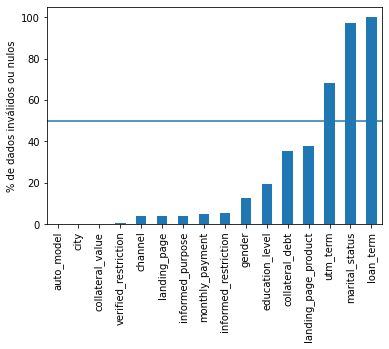

auto_model                0.006667
city                      0.053337
collateral_value          0.086672
verified_restriction      0.426695
channel                   3.766918
landing_page              3.766918
informed_purpose          3.886926
monthly_payment           5.000333
informed_restriction      5.373692
gender                   12.614174
education_level          19.247950
collateral_debt          35.382359
landing_page_product     38.035869
utm_term                 68.171211
marital_status           97.319821
loan_term               100.000000
dtype: float64


In [3]:
db_size = len(df)
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing_percentual = (missing/db_size)*100
missing_percentual.plot.bar()
plt.ylabel('% de dados inválidos ou nulos')
plt.axhline(y=50)
plt.show()
print(missing_percentual)

#### Como isso, entendemos que as váriáveis **utm_term**, **marital_status** e **loan_term** não serão utilizadas na análise. Que possuem mais 50% dos seus campos com valores inváidos

### 2) Análise de outliers

#### Começamos com as varáveis que apresentam distribuição dos valores de forma **contínua**.

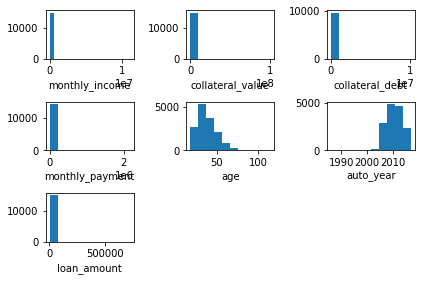

In [4]:
fig = plt.figure()

plt.subplot(3, 3, 1)
plt.hist(df['monthly_income'],bins=20)
plt.xlabel('monthly_income')

plt.subplot(3, 3, 2)
plt.hist(df['collateral_value'])
plt.xlabel('collateral_value')

plt.subplot(3, 3, 3)
plt.hist(df['collateral_debt'])
plt.xlabel('collateral_debt')

plt.subplot(3, 3, 4)
plt.hist(df['monthly_payment'])
plt.xlabel('monthly_payment')

plt.subplot(3, 3, 5)
plt.hist(df['age'])
plt.xlabel('age')

plt.subplot(3, 3, 6)
plt.hist(df['auto_year'])
plt.xlabel('auto_year')

plt.subplot(3, 3, 7)
plt.hist(df['loan_amount'])
plt.xlabel('loan_amount')

#espaçamento entre os subplots
fig.tight_layout()

plt.show()

#### como o espaço de parâmetros apresenta-se grande, colocamos o eixo Y em escala logarítimica para melhor visualização

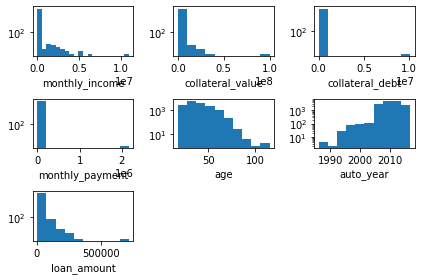

In [5]:
fig = plt.figure()

plt.subplot(3, 3, 1)
plt.hist(df['monthly_income'],bins=20)
plt.yscale('log')
plt.xlabel('monthly_income')

plt.subplot(3, 3, 2)
plt.hist(df['collateral_value'])
plt.yscale('log')
plt.xlabel('collateral_value')

plt.subplot(3, 3, 3)
plt.hist(df['collateral_debt'])
plt.yscale('log')
plt.xlabel('collateral_debt')

plt.subplot(3, 3, 4)
plt.hist(df['monthly_payment'])
plt.yscale('log')
plt.xlabel('monthly_payment')

plt.subplot(3, 3, 5)
plt.hist(df['age'])
plt.yscale('log')
plt.xlabel('age')

plt.subplot(3, 3, 6)
plt.hist(df['auto_year'])
plt.yscale('log')
plt.xlabel('auto_year')

plt.subplot(3, 3, 7)
plt.hist(df['loan_amount'])
plt.yscale('log')
plt.xlabel('loan_amount')

#espaçamento entre os subplots
fig.tight_layout()

plt.show()

#### podemos perceber, visualmente, a presença de outliers.

### Análise boxplot (quartis)

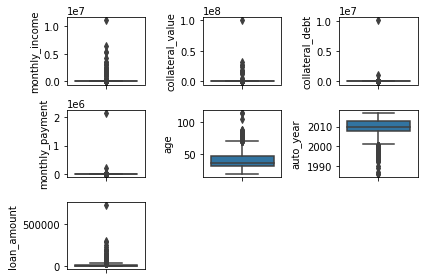

In [6]:
fig = plt.figure()

plt.subplot(3, 3, 1)
sns.boxplot(y=df['monthly_income'])

plt.subplot(3, 3, 2)
sns.boxplot(y=df['collateral_value'])

plt.subplot(3, 3, 3)
sns.boxplot(y=df['collateral_debt'])

plt.subplot(3, 3, 4)
sns.boxplot(y=df['monthly_payment'])

plt.subplot(3, 3, 5)
sns.boxplot(y=df['age'])

plt.subplot(3, 3, 6)
sns.boxplot(y=df['auto_year'])

plt.subplot(3, 3, 7)
sns.boxplot(y=df['loan_amount'])

fig.tight_layout()
plt.show()

#### Como o espaço de parâmetros está muito amplo, vamos setar o eixo Y em escala logarítimica para melhor visualização

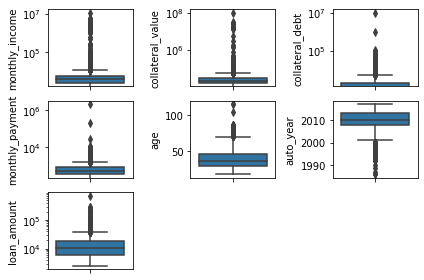

In [7]:
fig = plt.figure()

plt.subplot(3, 3, 1)
sns.boxplot(y=df['monthly_income'])
plt.yscale('log')

plt.subplot(3, 3, 2)
sns.boxplot(y=df['collateral_value'])
plt.yscale('log')

plt.subplot(3, 3, 3)
sns.boxplot(y=df['collateral_debt'])
plt.yscale('log')

plt.subplot(3, 3, 4)
sns.boxplot(y=df['monthly_payment'])
plt.yscale('log')

plt.subplot(3, 3, 5)
sns.boxplot(y=df['age'])

plt.subplot(3, 3, 6)
sns.boxplot(y=df['auto_year'])

plt.subplot(3, 3, 7)
sns.boxplot(y=df['loan_amount'])
plt.yscale('log')

fig.tight_layout()
plt.show()

#### Agora podemos remover os outliers baseado nas distribuições entre os quartis (IQR)

In [8]:
Q1 = df['monthly_income'].quantile(0.25)
Q3 = df['monthly_income'].quantile(0.75)
IQR = Q3 - Q1
df_sem_outliers = df[~((df['monthly_income']< (Q1 - 1.5 * IQR)) |(df['monthly_income']> (Q3 + 1.5 * IQR)))]

Q1 = df['collateral_value'].quantile(0.25)
Q3 = df['collateral_value'].quantile(0.75)
IQR = Q3 - Q1
df_sem_outliers = df_sem_outliers[~((df_sem_outliers['collateral_value']< (Q1 - 1.5 * IQR)) |(df_sem_outliers['collateral_value']> (Q3 + 1.5 * IQR)))]

Q1 = df['collateral_debt'].quantile(0.25)
Q3 = df['collateral_debt'].quantile(0.75)
IQR = Q3 - Q1
df_sem_outliers = df_sem_outliers[~((df_sem_outliers['collateral_debt']< (Q1 - 1.5 * IQR)) |(df_sem_outliers['collateral_debt']> (Q3 + 1.5 * IQR)))]

Q1 = df['monthly_payment'].quantile(0.25)
Q3 = df['monthly_payment'].quantile(0.75)
IQR = Q3 - Q1
df_sem_outliers = df_sem_outliers[~((df_sem_outliers['monthly_payment']< (Q1 - 1.5 * IQR)) |(df_sem_outliers['monthly_payment']> (Q3 + 1.5 * IQR)))]

Q1 = df_sem_outliers['age'].quantile(0.25)
Q3 = df_sem_outliers['age'].quantile(0.75)
IQR = Q3 - Q1
df_sem_outliers = df_sem_outliers[~((df_sem_outliers['age']< (Q1 - 1.5 * IQR)) |(df_sem_outliers['age']> (Q3 + 1.5 * IQR)))]

Q1 = df['auto_year'].quantile(0.25)
Q3 = df['auto_year'].quantile(0.75)
IQR = Q3 - Q1
df_sem_outliers = df_sem_outliers[~((df_sem_outliers['auto_year']< (Q1 - 1.5 * IQR)) |(df_sem_outliers['auto_year']> (Q3 + 1.5 * IQR)))]

Q1 = df['loan_amount'].quantile(0.25)
Q3 = df['loan_amount'].quantile(0.75)
IQR = Q3 - Q1
df_sem_outliers = df_sem_outliers[~((df_sem_outliers['loan_amount']< (Q1 - 1.5 * IQR)) |(df_sem_outliers['loan_amount']> (Q3 + 1.5 * IQR)))]
print(1 - len(df_sem_outliers)/len(df))

0.23594906327088472


#### Isto resultou em uma perda de ~**24%** dos dados.

#### Abaixo, a nova distribuição das variáveis (boxplot) após remoção dos outliers

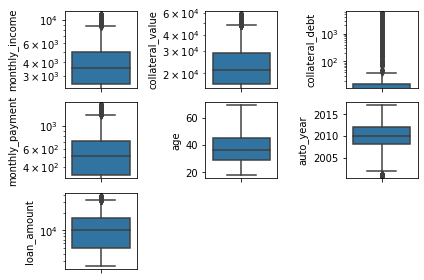

In [9]:
fig = plt.figure()

plt.subplot(3, 3, 1)
sns.boxplot(y=df_sem_outliers['monthly_income'])
plt.yscale('log')

plt.subplot(3, 3, 2)
sns.boxplot(y=df_sem_outliers['collateral_value'])
plt.yscale('log')

plt.subplot(3, 3, 3)
sns.boxplot(y=df_sem_outliers['collateral_debt'])
plt.yscale('log')

plt.subplot(3, 3, 4)
sns.boxplot(y=df_sem_outliers['monthly_payment'])
plt.yscale('log')

plt.subplot(3, 3, 5)
sns.boxplot(y=df_sem_outliers['age'])

plt.subplot(3, 3, 6)
sns.boxplot(y=df_sem_outliers['auto_year'])

plt.subplot(3, 3, 7)
sns.boxplot(y=df_sem_outliers['loan_amount'])
plt.yscale('log')

# set the spacing between subplots
fig.tight_layout()
plt.show()

#### Histograma com a nova distribuição das variáveis contínuas.

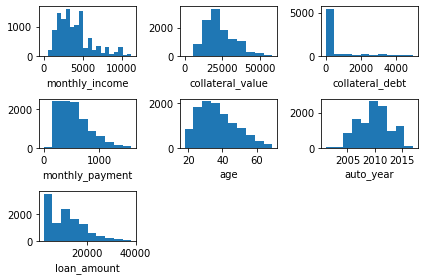

In [10]:
fig = plt.figure()

plt.subplot(3, 3, 1)
plt.hist(df_sem_outliers['monthly_income'],bins=20)
plt.xlabel('monthly_income')

plt.subplot(3, 3, 2)
plt.hist(df_sem_outliers['collateral_value'])
plt.xlabel('collateral_value')

plt.subplot(3, 3, 3)
plt.hist(df_sem_outliers['collateral_debt'])
plt.xlabel('collateral_debt')

plt.subplot(3, 3, 4)
plt.hist(df_sem_outliers['monthly_payment'])
plt.xlabel('monthly_payment')

plt.subplot(3, 3, 5)
plt.hist(df_sem_outliers['age'])
plt.xlabel('age')

plt.subplot(3, 3, 6)
plt.hist(df_sem_outliers['auto_year'])
plt.xlabel('auto_year')

plt.subplot(3, 3, 7)
plt.hist(df_sem_outliers['loan_amount'])
plt.xlabel('loan_amount')

fig.tight_layout()

plt.show()

#### Note que a variável **collateral_debt** não segue nenhum padrão de distribuição mesmo com a remoção dos outliers. Isso é um indicativo que não é uma variável adequada a ser utilizada.

### 3) Fit das distribuições a partir de modelos conhecidos
#### O fit é importante para entender quais variáveis são potenciais para serem utilizadas no modelo de classificação.
#### Façamos agora um fit gaussiano nessas distribuições com o intuito de entender seu comportamento. Note que, visualmente, elas **não** tem perfis de distribuição normal (devido à presença de "cauda", i.e. assimetria na distribuição).

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Ple

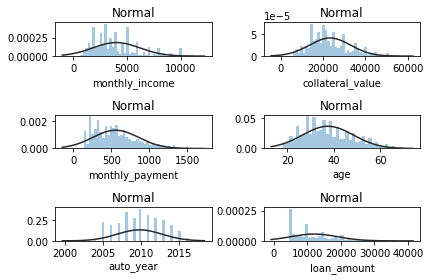

In [11]:
fig = plt.figure()

plt.subplot(3, 2, 1)
y = df_sem_outliers['monthly_income']
plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.xlabel('monthly_income')

plt.subplot(3, 2, 2)
plt.title('Normal')
y = df_sem_outliers['collateral_value']
sns.distplot(y, kde=False, fit=st.norm)
plt.xlabel('collateral_value')

plt.subplot(3, 2, 3)
plt.title('Normal')
y = df_sem_outliers['monthly_payment']
sns.distplot(y, kde=False, fit=st.norm)
plt.xlabel('monthly_payment')

plt.subplot(3, 2, 4)
plt.title('Normal')
y = df_sem_outliers['age']
sns.distplot(y, kde=False, fit=st.norm)
plt.xlabel('age')

plt.subplot(3, 2, 5)
plt.title('Normal')
y = df_sem_outliers['auto_year']
sns.distplot(y, kde=False, fit=st.norm)
plt.xlabel('auto_year')

plt.subplot(3, 2, 6)
plt.title('Normal')
y = df_sem_outliers['loan_amount']
sns.distplot(y, kde=False, fit=st.norm)
plt.xlabel('loan_amount')
# set the spacing between subplots
fig.tight_layout()

plt.show()

#### Devido à presença de assimetria nas distribuições, escolhemos um modelo que contempla tal característica. Como por exemplo, a distribuição de Johnson SU [1]
#### *[1] Johnson, N. L. (1949). Systems of frequency curves generated by methods of translation. Biometrika, 36(1/2), 149-176.*

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Ple

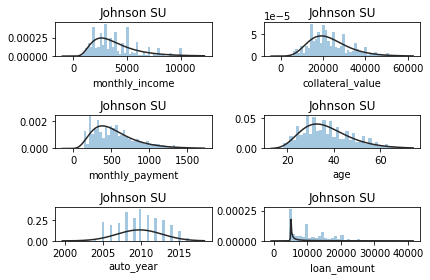

In [12]:
fig = plt.figure()

plt.subplot(3, 2, 1)
y = df_sem_outliers['monthly_income']
plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.xlabel('monthly_income')

plt.subplot(3, 2, 2)
plt.title('Johnson SU')
y = df_sem_outliers['collateral_value']
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.xlabel('collateral_value')

plt.subplot(3, 2, 3)
plt.title('Johnson SU')
y = df_sem_outliers['monthly_payment']
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.xlabel('monthly_payment')

plt.subplot(3, 2, 4)
plt.title('Johnson SU')
y = df_sem_outliers['age']
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.xlabel('age')

plt.subplot(3, 2, 5)
plt.title('Johnson SU')
y = df_sem_outliers['auto_year']
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.xlabel('auto_year')

plt.subplot(3, 2, 6)
plt.title('Johnson SU')
y = df_sem_outliers['loan_amount']
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.xlabel('loan_amount')

# set the spacing between subplots
fig.tight_layout()

plt.show()

#### Podemos observar que a variável **auto_year** (i.e. o ano do veículo dado como garantia), não se adapta bem à nenhuma das distribuições. O que indica que também não seria adequado utilizá-la na análise na forma como se apresenta. Possivelmente se tal variável fosse convertida em uma variável categórica, pode funcionar melhor. Mas essse teste não foi realizado neste trabalho.

## 4) Análise dos dados categóricos
### Plots de todas as variáveis categóricas e suas respectivas probabilidades

#### Tratamento das variáveis **education_level** e **channel**:

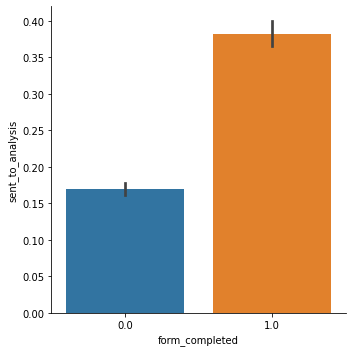

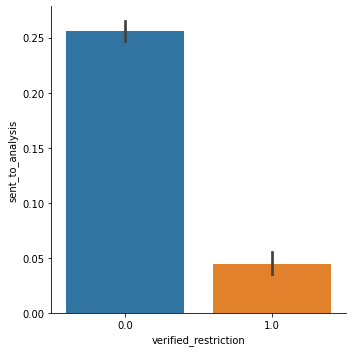

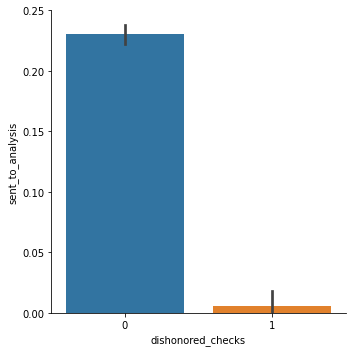

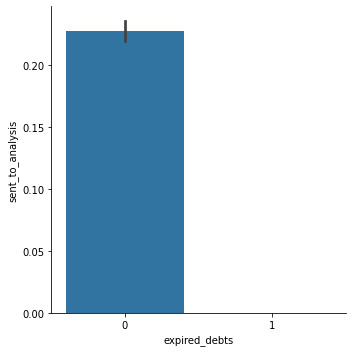

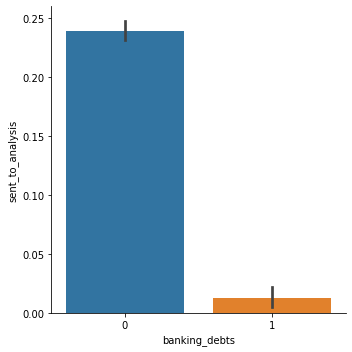

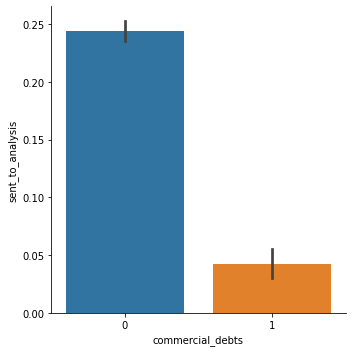

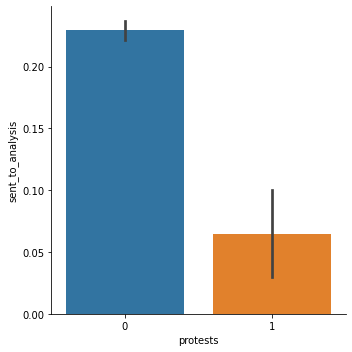

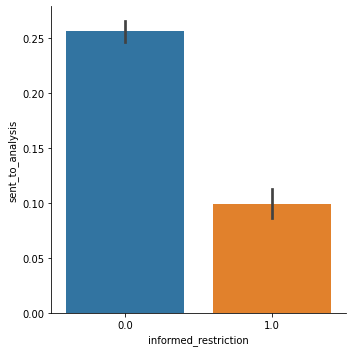

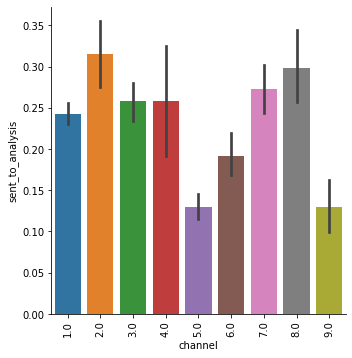

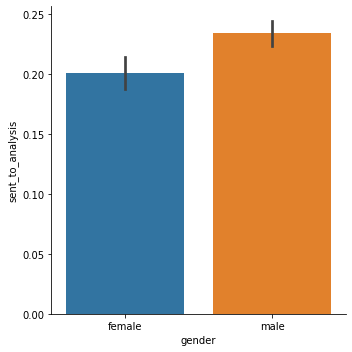

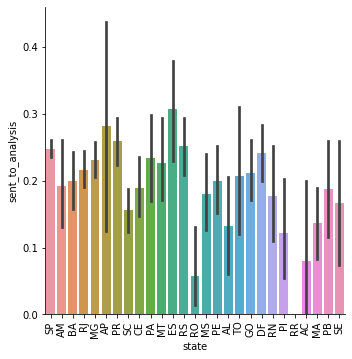

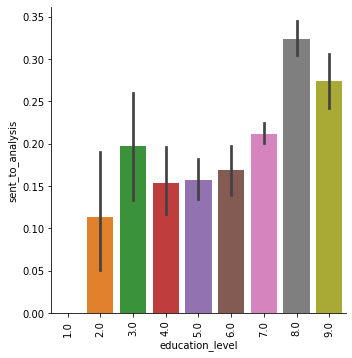

In [13]:
cleanup_education_level = {"education_level":     {"Analfabeto, inclusive o que, embora tenha recebido instrução, não se alfabetizou.": 1, 
                                        "Até a 4ª série incompleta do ensino fundamental (antigo 1º grau ou primário), que se tenha alfabetizado sem ter freqüentado escola regular.": 2,
                                        "4ª série completa do ensino fundamental (antigo 1º grau ou primário).":3,
                                        "Da 5ª à 8ª série do ensino fundamental (antigo 1º grau ou ginásio).":4,
                                        "Ensino fundamental completo (antigo 1º grau ou primário e ginasial).":5,
                                        "Ensino médio incompleto (antigo 2º grau, secundário ou colegial).":6,
                                        "Ensino médio completo (antigo 2º grau, secundário ou colegial).":7,
                                        "Educação superior completa":8,"Educação superior incompleta.":9},}
df_sem_outliers = df_sem_outliers.replace(cleanup_education_level)

cleanup_channel = {"channel":     {"search":1,"direct":2,"affiliates":3,"social":4,
                                   "display":5,"remarketing":6,"seo":7,"referral":8,"emailaffiliates":9}}
df_sem_outliers = df_sem_outliers.replace(cleanup_channel)

sns.catplot(x="form_completed", y="sent_to_analysis", kind="bar", data=df_sem_outliers)
sns.catplot(x="verified_restriction", y="sent_to_analysis", kind="bar", data=df_sem_outliers)
sns.catplot(x="dishonored_checks", y="sent_to_analysis", kind="bar", data=df_sem_outliers)
sns.catplot(x="expired_debts", y="sent_to_analysis", kind="bar", data=df_sem_outliers)
sns.catplot(x="banking_debts", y="sent_to_analysis", kind="bar", data=df_sem_outliers)
sns.catplot(x="commercial_debts", y="sent_to_analysis", kind="bar", data=df_sem_outliers)
sns.catplot(x="protests", y="sent_to_analysis", kind="bar", data=df_sem_outliers)
sns.catplot(x="informed_restriction", y="sent_to_analysis", kind="bar", data=df_sem_outliers)
sns.catplot(x="channel", y="sent_to_analysis", kind="bar", data=df_sem_outliers)
plt.xticks(rotation=90)
sns.catplot(x="gender", y="sent_to_analysis", kind="bar", data=df_sem_outliers)
sns.catplot(x="state", y="sent_to_analysis", kind="bar", data=df_sem_outliers)
plt.xticks(rotation=90)
#sns.catplot(x="landing_page", y="sent_to_analysis", kind="bar", data=df_sem_outliers)
#plt.xticks(rotation=90)
#sns.catplot(x="landing_page_product", y="sent_to_analysis", kind="bar", data=df_sem_outliers)
#plt.xticks(rotation=90)
sns.catplot(x="education_level", y="sent_to_analysis", kind="bar", data=df_sem_outliers)
plt.xticks(rotation=90)
# set the spacing between subplots
fig.tight_layout()
plt.show()

#### A partir desse ponto escolheremos quais variáveis iremos utilizar para o modelo. Variáveis de **gênero**, **região** (cep, cidade, estado) e **nível de escolaridade** não foram utilizadas devido ao seu potencial de criação de viéses indesejados - de caráter social. Mas é válido que isso seja discutido com outras equipes para se entender qual procedimento deverá ser feito. 
#### As variáveis **landing_page**, **landing_page_product** e **informed_purpose** também não foram utilizadas devido as suas complexidades categóricas, ou seja, muitas subcategorias disponíveis textuais. Mas é valido um tratamento especial nessa categoria de variável.
#### A variável **expired_debts** foi removida, pois como foi observado, somente apresenta valores iguais a zero, de forma que não altera a capacidade preditiva do modelo.

## 5) Grau de correlação das variáveis contínuas

#### Das variáveis que não foram excluídas da análise, vamos medir o grau de correlação entre variáveis do modelo, assim como *insights* criação de novas variáveis a partir de outras. Como, por exemplo, a **income_compromising = monthly_payment/monthly_income** e **collateral_loan_amount_ratio =  loan_amount/collateral_value**. Respectivamente, para medir o grau de comprometimento de renda do cliente e a razão entre a garantia oferecida e o valor solicitado do empréstimo.

#### Variáveis com grau de correlção superior à 0.8 são removidas. Podemos perceber que a variável **monthly_payment** e **loan_amount** são altamente correlacionadas. Como a variável **monthly_payment** será usada em outra (**income_compromising**), escolhemos excluir da análise a variável **monthly_payment**.

                               channel  monthly_income  monthly_payment  \
channel                       1.000000       -0.015028        -0.009931   
monthly_income               -0.015028        1.000000         0.475869   
monthly_payment              -0.009931        0.475869         1.000000   
collateral_value             -0.027114        0.308976         0.406242   
age                           0.118777        0.194231         0.096679   
loan_amount                   0.020489        0.404510         0.814894   
collateral_loan_amount_ratio  0.014979        0.024038         0.020307   
income_compromising           0.015058       -0.464387         0.443933   

                              collateral_value       age  loan_amount  \
channel                              -0.027114  0.118777     0.020489   
monthly_income                        0.308976  0.194231     0.404510   
monthly_payment                       0.406242  0.096679     0.814894   
collateral_value                

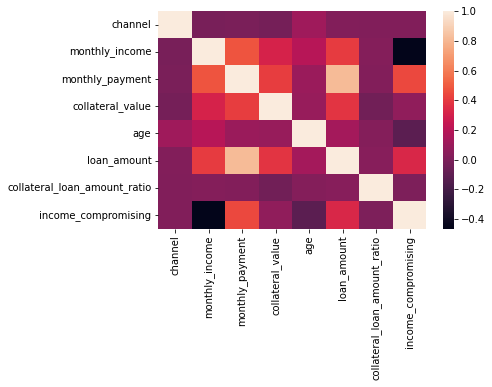

In [33]:
df_sem_outliers['income_compromising'] = df_sem_outliers['monthly_payment']/df_sem_outliers['monthly_income']
df_sem_outliers['collateral_loan_amount_ratio'] = df_sem_outliers['loan_amount']/df_sem_outliers['collateral_value']

corr = df_sem_outliers[['channel',
                        'monthly_income',
                        'monthly_payment',
                        'collateral_value',
                        'age',
                        'loan_amount',
                        'collateral_loan_amount_ratio',
                        'income_compromising']].corr()
print(corr)
sns.heatmap(corr)
plt.show()

## 6) Removendo todas as variáveis que não serão utilizadas no modelo.
#### Removento entradas nulas. Isso impactou na perda de ~**10%** dos dados.

In [34]:
df_aux = df_sem_outliers.drop(['id',
                      'loan_term',
                      'monthly_payment',
                      'collateral_debt',
                      'expired_debts',
                      'city',
                      'state',
                      'marital_status',
                      'education_level',
                      'informed_purpose',
                      'auto_brand',
                      'auto_model',
                      'auto_year',
                      'pre_approved',
                      'zip_code',
                      'landing_page',
                      'landing_page_product',
                      'gender',
                      'utm_term'],axis=1)
df_sem_nans = df_aux.dropna()
print(1 - len(df_sem_nans)/len(df_sem_outliers))


0.09563699825479932


## 7) Normalização dos dados
#### A normalização dos dados é uma técnica padrão com o objetivo de alterar os valores das colunas numéricas no conjunto de dados para uma escala comum, sem distorcer as diferenças nos intervalos de valores.

In [16]:
def min_max_scaling(df):
    
    df_norm = df.copy()
    norm_cols = ['channel','collateral_value','loan_amount','monthly_income','age','collateral_loan_amount_ratio','income_compromising']
    
    for column in norm_cols:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
    return df_norm
    
df_normalizado = min_max_scaling(df_sem_nans)

## 8) Análise da variável *target* - Desbalanceamento dos dados

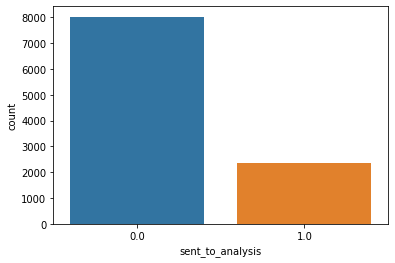

In [17]:
sns.countplot(x="sent_to_analysis", data=df_normalizado)
#g.set_xticklabels(['Nao Enviado','Enviado'])
plt.show()

#### Podemos observar um claro desbalanceamento dos dados.

#### Vamos aplicar a técnica SMOT (Synthetic Minority Oversampling Technique) onde desejamos aumentar o número de entradas na amostra para que a proporção de enviados e não-enviados para análise de crétido seja equivalente. Dessa forma nossos dados estarão balanceados. 
#### Não é obvio na literatura qual a melhor técnica a ser utilizada, a nível de dados ou de algoritimo (i.e. penalização estatística ao final). Mas como estamos lidando com um dataset relativamente pequeno, em caráter de otimização, não é uma tarefa inexequível. 
#### Mas é válido ressaltar que existem diversas maneiras diferentes para realizar de forma optimal para cada tipo de problema, e também se mostra válido uma comparação quantitativa entre os métodos em uma análise futura.

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


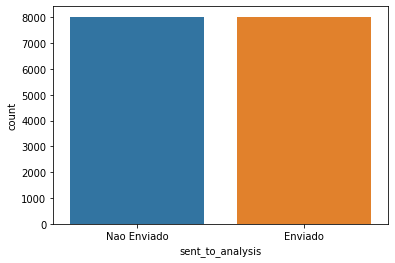

In [18]:
X = df_normalizado.drop('sent_to_analysis',axis=1)
Y = df_normalizado['sent_to_analysis']
# transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)
# visualize the target variable

g = sns.countplot(Y)
g.set_xticklabels(['Nao Enviado','Enviado'])
plt.show()

#### Podemos observar que os dados se encontram balanceados.

# 9) Modelos

## 9.1) Regressão Logística
#### Começamos pelo modelo mais básico de classificação com probabilidades.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=101) 
model = LogisticRegression()
model.fit(X_train, y_train)

y_predicted = model.predict(X_test)
pred_prob = model.predict_proba(X_test)

pred_prob_train = model.predict_proba(X_train)
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

         0.0       0.64      0.67      0.65      2385
         1.0       0.66      0.64      0.65      2429

    accuracy                           0.65      4814
   macro avg       0.65      0.65      0.65      4814
weighted avg       0.65      0.65      0.65      4814



### 9.1.1) Métricas de Avaliação - AUC, GINI e KS
#### Utilizaremos na análise a seguir sempre essas 3 métricas para comparativo de modelos. Tais métricas serão utilizadas devido, principalmente, a popularidade em que são utilizadas no contexto atual de análise de crédito. Alguns autores descrevem que a AUC pode ser mais eficiente que o KS [2]. Mas é valido ressaltar a existência de outras métricas na literatura.

#### [2] *Credit Scoring: Desenvolvimento, Implantação, Acompanhamento, Abraham Laredo Sicsú. Pg. 105*  

AUC - Test Set: 65.14%
GINI Index: 0.30


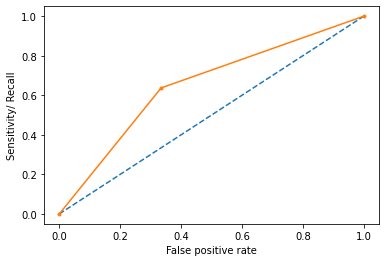

In [20]:
auc = roc_auc_score(y_test, y_predicted)

print('AUC - Test Set: %.2f%%' % (auc*100))
print('GINI Index: %.2f'% (2*(auc-0.5)))

#Plot AUC
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
plt.show()

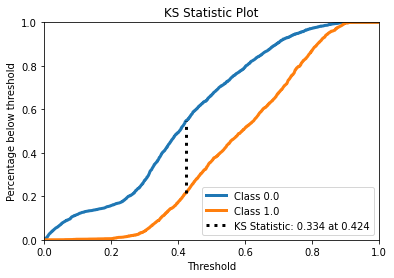

In [21]:
#Plot KS - TESTE
skplt.metrics.plot_ks_statistic(y_test, pred_prob)
plt.show()

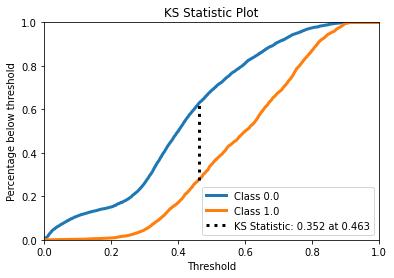

In [22]:
#Plot KS - TREINO
skplt.metrics.plot_ks_statistic(y_train, pred_prob_train)
plt.show()

### 9.1.2) Análise SHAP
#### Com a análise SHAP podemos verificar de forma gráfica quais variáveis impactam mais o modelo preditivo.

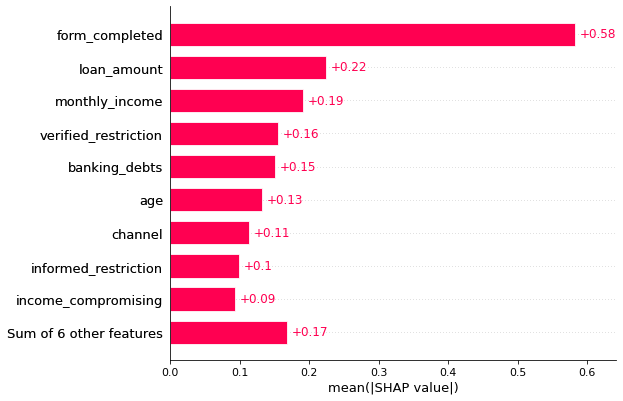

In [23]:
masker = shap.maskers.Independent(data=X_test)
explainer = shap.LinearExplainer(model, masker=masker)

# explain the model on two sample inputs
shap_values = explainer(X_test)

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.bar(shap_values)

## 9.2) Random Forest
#### Passamos para um modelo mais sofisticado e muito utilizado em análise de crédito.

In [24]:
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size=0.30,
                                                    random_state=101)

clf = RandomForestClassifier(max_depth=2, random_state=42)
a = clf.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions = clf.predict(test_features)
pred_prob = clf.predict_proba(test_features)
pred_prob_train = clf.predict_proba(train_features)

### 9.2.1) Métricas de Avaliação - AUC, GINI e KS

AUC - Test Set: 67.92%
GINI Index: 0.36


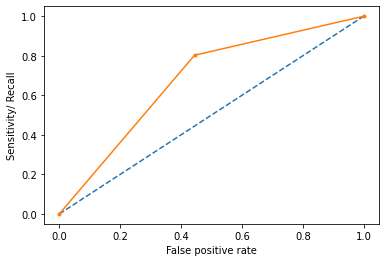

In [25]:
#AUC
auc = roc_auc_score(test_labels, predictions)
print('AUC - Test Set: %.2f%%' % (auc*100))
print('GINI Index: %.2f'% (2*(auc-0.5)))

#Plot AUC
fpr, tpr, thresholds = roc_curve(test_labels, predictions)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show()

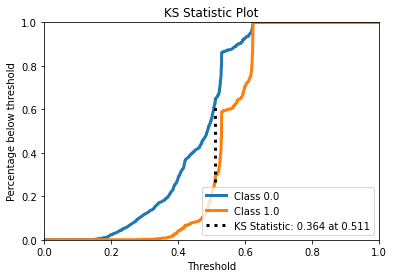

In [26]:
#KS - TESTE
skplt.metrics.plot_ks_statistic(test_labels, pred_prob)
plt.show()

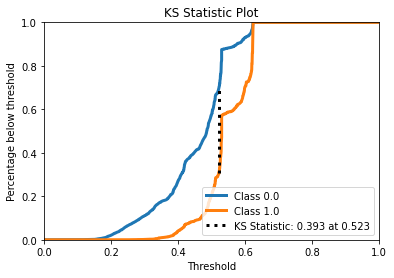

In [27]:
#KS - TREINO
skplt.metrics.plot_ks_statistic(train_labels, pred_prob_train)
plt.show()

## 9.3) GBOOST
#### Passamos para um modelo também muito utilizado na análise de crédito e similar ao Random Forest, mas com algumas peculiaridades que podem fazer diferença dependendo da análise aplicada. Por isso vale colocar também este modelo para comparação. Este modelo se mostrou computacionalmente mais veloz que o Random Forest, apesar de ser apenas um insight qualitativo. 

In [28]:
#GBOOST
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=101) 

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=0).fit(X_train, y_train)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)
pred_prob_train = clf.predict_proba(X_train)

### 9.3.1) Métricas de Avaliação - AUC, GINI e KS

AUC - Test Set: 74.54%
GINI Index: 0.49


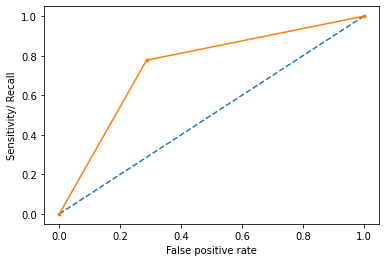

In [29]:
#AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC - Test Set: %.2f%%' % (auc*100))
print('GINI Index: %.2f'% (2*(auc-0.5)))

#Plot AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show()

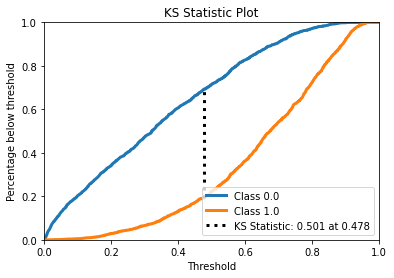

In [30]:
#KS - TESTE
skplt.metrics.plot_ks_statistic(y_test, pred_prob)
plt.show()

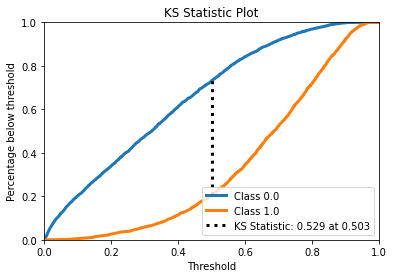

In [31]:
#KS - TREINO
skplt.metrics.plot_ks_statistic(y_train, pred_prob_train)
plt.show()

# 10) Conclusões e Resultados

| Modelo | AUC | GINI | KS Teste| KS Treino |
|---|---|---|---|---|
| Regressão Logística | 0.66 | 0.32 | 0.34 | 0.35 |
| Random Forest | 0.68 | 0.37 | 0.37 | 0.35 |
| GBOOST | 0.75 | 0.50 | 0.51 | 0.52 |

#### Considerando o modelo de regressão logística como nosso baseline, podemos verificar o ganho quantitiativo nos modelos de Random Forest e GBOOST

| Modelo | AUC | GINI | KS Teste| KS Treino |
|---|---|---|---|---|
| Random Forest | +3% | +15.6% | +8.8% | 0% |
| GBOOST | +13,6% | +35,1% | +37,8% | +48,5% |

#### Com isso verificamos que o modelo GBOOST se mostrou mais interessante de ponto de vista prático, já que suas métricas se mostraram superiores. No entanto, todos os modelos tiveram comportamentos interessantes.

# 11) Próximos passos

#### Sobre esta análise apresentada, algumas lacunas podem ser preenchidas. Entre elas, destaco 3 pontos:
#### 1) Aprofundamento da análise em relação ao valor dado de garantia. O valor é preenchido pelo cliente, sem validação com a tabela FIPE, por exemplo. Como sugestão, seria possível inferir o valor de garantia a partir de dados externos utilizando as informações preeenchidas refernte ao veículo. Outro ponto refente à análise do veículo, como mencionado antes, seria categorizar a variável **auto_year**.

#### 2) Aprofondamento na análise referente às variáveis textuais, como o "propósito do empréstimo", por exemplo.

#### 3) Aprofundamento nas técnicas de balanceamento de dados para inferir se existe um impacto significtivo nas diferentes técnicas.
